# Partial Image Velocimetry


Based on OpenPIV Tutorial 1

In [1]:
from openpiv import tools, process, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import imageio
import tiff_file
import seaborn as sb

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


# Read in frames and show

In [2]:
exp = '20200918_5.8 AMT 75%actin'
trial = '3'
filename = '3_+488_30min.nd2 - C=0'
data_dir = 'Y:\\Gloria\\Confocal Videos\\'+exp+'\\raw tiffs\\'
saveto = 'Y:\\Gloria\\Confocal Videos\\'+exp+'\\PIV\\'+trial+'\\'

a=10
b=a+100

frame_a  = tiff_file.imread( data_dir+filename+'.tif')[a]
frame_b  = tiff_file.imread( data_dir+filename+'.tif')[b]


tiff_file.py:725: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for p in pages)


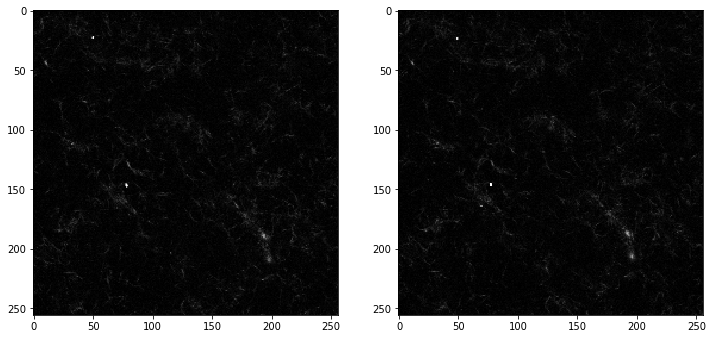

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [4]:
plt.imsave(saveto+filename+'_%i.tif'%a, frame_a)
plt.imsave(saveto+filename+'_%i.tif'%b, frame_b)

# Perform PIV and generate vector field

In [5]:
winsize = 24 # pixels, 256/winsize= # of windows frame a will be broken into
searchsize = 64  # pixels, search in image B, size of total area in frame b that each section of frame a will be compared to
overlap = 12 # pixels, how far each area in frame b will overlap adjacent area
fps=2.78 #framerate=2.78 frames per second
dt = (b-a)/fps # sec, time lapse between frames
'''
winsize = 24 # pixels
searchsize = 64  # pixels, search in image B
overlap = 12 # pixels
dt = 0.02 # sec
'''
u0, v0, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )

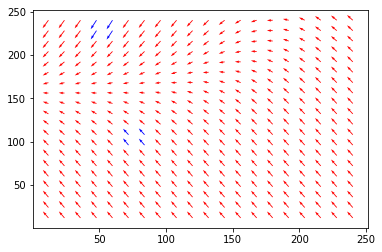

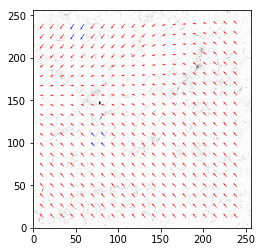

In [6]:
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )

u1, v1, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 3.5 ) #threshold is signal/noise ratio, the higher you set it, the more 'noise' it cuts out. validation only keeps non-noise vectors

u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2) #for any vectors cut out by validation, replace_outliers fills these vectors back in by weight-averaging the neighboring vectors

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 1 )

tools.save(x, y, u3, v3, mask, saveto+filename+'_PIV.txt' )
tools.save(x, y, u3, v3, mask, saveto+filename+'_PIV.p' )

tools.display_vector_field(saveto+filename+'_PIV.txt', scale=1, width=0.0025)

tools.display_vector_field(saveto+filename+'_PIV.txt', on_img=True, 
                                          image_name=saveto+filename+'_%i.tif'%a, 
                                          window_size=32, scaling_factor=1, 
                                          scale=1, width=0.0025)


# Probability Distribution

([array([3., 2., 1., 2., 1., 8., 1., 1., 1., 0.]),
  array([3., 2., 1., 2., 1., 8., 1., 1., 1., 0.]),
  array([3., 2., 1., 2., 1., 8., 1., 1., 1., 0.]),
  array([3., 2., 1., 2., 1., 8., 1., 0., 0., 2.]),
  array([3., 2., 0., 2., 2., 8., 1., 0., 0., 2.]),
  array([3., 2., 0., 2., 1., 9., 1., 1., 1., 0.]),
  array([3., 1., 2., 1., 1., 9., 1., 2., 0., 0.]),
  array([3., 1., 2., 1., 2., 9., 1., 1., 0., 0.]),
  array([3., 1., 2., 2., 1., 9., 2., 0., 0., 0.]),
  array([ 3.,  2.,  2.,  1.,  2., 10.,  0.,  0.,  0.,  0.]),
  array([3., 1., 2., 2., 4., 8., 0., 0., 0., 0.]),
  array([3., 2., 3., 2., 2., 8., 0., 0., 0., 0.]),
  array([3., 3., 2., 1., 2., 9., 0., 0., 0., 0.]),
  array([5., 1., 1., 2., 2., 9., 0., 0., 0., 0.]),
  array([ 4.,  1.,  2.,  1.,  2., 10.,  0.,  0.,  0.,  0.]),
  array([ 3.,  1.,  2.,  1.,  2., 11.,  0.,  0.,  0.,  0.]),
  array([ 0.,  3.,  1.,  2.,  2., 12.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  2.,  2.,  3., 13.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  3.,  3.

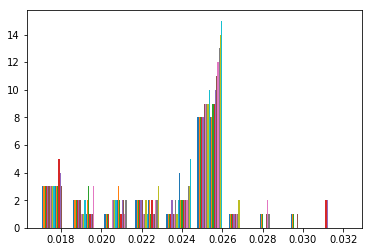

In [158]:
v_tot=(u3**2+v3**2)**0.5
np.histogram(v_tot)
plt.hist(v_tot)

# Divergence

In [7]:
xx=x[0,2]-x[0,0]
yy=y[2,0]-y[0,0]

div_x=np.zeros((len(u3[0,:]),len(v3[:,0])))
div_y=np.zeros((len(u3[0,:]),len(v3[:,0])))
div=np.zeros((len(u3[0,:]),len(v3[:,0])))

for j in range(len(u3[0,:])-1):
        for i in range(len(u3[0,:])-1):
            div_x[i,j]=(u3[i+1,j]-u3[i-1,j])/xx
            div_y[i,j]=(v3[i,j+1]-v3[i,j-1])/yy
            div=div_x+div_y


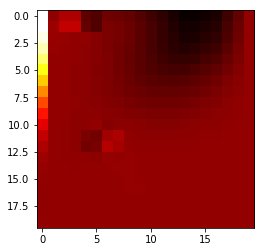

In [32]:
plt.imshow(div, cmap='hot', interpolation='nearest')
plt.show()

In [33]:
fig=plt.cm.hot(div)

plt.imsave(saveto+filename+'_div.png',fig)

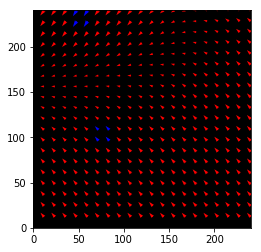

In [34]:
tools.display_vector_field(saveto+filename+'_PIV.txt', on_img=True, 
                                          image_name=saveto+filename+'_div.png', 
                                          window_size=16, scaling_factor=82800, 
                                          scale=1, width=0.01)

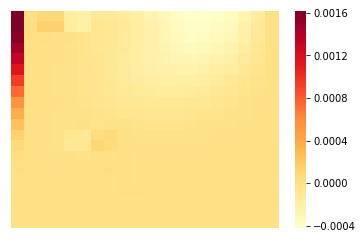

In [29]:
fig1=sb.heatmap(div,xticklabels=False,yticklabels=False,cmap='YlOrRd' )
plt.show()

In [30]:
figure=fig1.get_figure()
figure.savefig(saveto+filename+'_div.png')

AttributeError: 'str' object has no attribute 'readline'

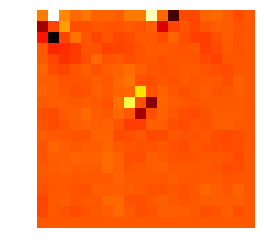

In [17]:
img = plt.imshow(div, cmap='hot')
plt.axis('off')

data=pickle.load('C:\\Users\\adminranderson\\Desktop\\exp1_001.p')
plt.quiver(data[0], data[1], data[2], data[3], data[4], scale=10)
plt.show()

#plt.savefig("PIV_Substack_(23,25)_quiverplot_scale10.png", dpi=300)

